In [1]:
import pandas as pd
import numpy as np

### Load the data

In [2]:
dataset = pd.read_csv('./dataset/cleaned_dataset.csv')
print(dataset.shape)
print(dataset.head(10))
print(dataset.describe())

(20620, 2)
   label                                              tweet
0      1   rt  boy dats coldtyga dwn bad for cuffin dat ...
1      1   rt  dawg rt  you ever fuck a bitch and she st...
2      1          rt ganderson based she look like a tranny
3      1   rt  the shit you hear about me might be true ...
4      1  madisonx the shit just blows meclaim you so fa...
5      1  brighterdays i can not just sit up and hate on...
6      1  8220 cause im tired of you big bitches coming ...
7      1   amp you might not get ya bitch back amp thats...
8      1               hobbies include fighting mariambitch
9      1   keeks is a bitch she curves everyone  lol i w...
              label
count  20620.000000
mean       0.930650
std        0.254055
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000


In [3]:
from sklearn.model_selection import train_test_split

X = dataset['tweet']  # Input features
y = dataset['label']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Training set shape: ", X_train.shape, "\nLabel distribution: \n", y_train.value_counts())
print("\nTesting set shape: ", X_test.shape, "\nLabel distribution: \n", y_test.value_counts())

Training set shape:  (15465,) 
Label distribution: 
 label
1    14358
0     1107
Name: count, dtype: int64

Testing set shape:  (5155,) 
Label distribution: 
 label
1    4832
0     323
Name: count, dtype: int64


### Feature engineering and imbalanced data handling

In [11]:
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply TF-IDF vectorization to convert text data into numerical features
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Apply informed undersampling only to the training set
enn = EditedNearestNeighbours()
X_train_resampled, y_train_resampled = enn.fit_resample(X_train_tfidf, y_train)

print("After undersampling:\n")
print("Training set shape: ", X_train_resampled.shape)
print("Label distribution:\n", pd.Series(y_train_resampled).value_counts())

After undersampling:

Training set shape:  (13518, 18863)
Label distribution:
 label
1    12411
0     1107
Name: count, dtype: int64


### Model Training & Evaluation

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Train Logistic Regression model with L1 regularization
logistic_regression_model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)  # Adjust max_iter as needed
logistic_regression_model.fit(X_train_resampled, y_train_resampled)

# Train Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust n_estimators as needed
random_forest_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

### Model Evaluation

Logistic Regression
                    precision    recall  f1-score   support

       Hate Speech       0.44      0.40      0.42       323
Offensive Language       0.96      0.97      0.96      4832

          accuracy                           0.93      5155
         macro avg       0.70      0.68      0.69      5155
      weighted avg       0.93      0.93      0.93      5155

Random Forest
                    precision    recall  f1-score   support

       Hate Speech       0.45      0.45      0.45       323
Offensive Language       0.96      0.96      0.96      4832

          accuracy                           0.93      5155
         macro avg       0.71      0.70      0.71      5155
      weighted avg       0.93      0.93      0.93      5155



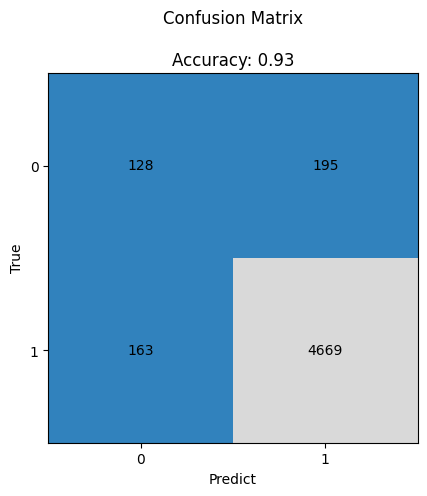

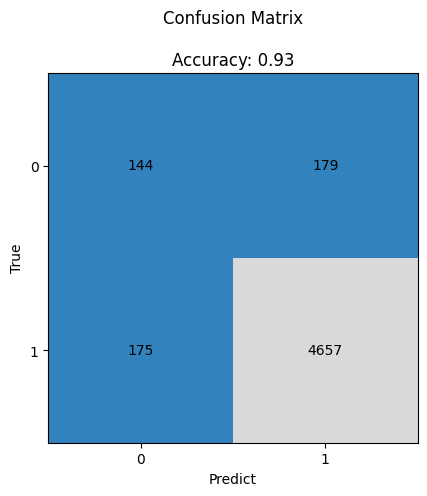

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt

models = [logistic_regression_model, random_forest_model]
model_names = ['Logistic Regression', 'Random Forest']

for i, model in enumerate(models):
    y_predict = model.predict(X_test_tfidf)
    
    # Evaluate models by the classification report
    print(model_names[i])
    print(classification_report(y_test, y_predict, target_names=['Hate Speech', 'Offensive Language']))

    # Evaluate models by the confusion matrix
    grid = confusion_matrix(y_test, y_predict)
    accuracy = accuracy_score(y_test, y_predict)

    # Create a confusion matrix plot
    fig, ax = plt.subplots()

    # Plot the confusion matrix
    for (j, i), label in np.ndenumerate(grid):
        ax.text(i, j, label, ha='center', va='center')

    ax.set_title(f'Confusion Matrix\n\nAccuracy: {accuracy:.2f}')
    ax.imshow(grid, cmap='tab20c')
    ax.set_xticks([1, 0])
    ax.set_yticks([1, 0])
    ax.set_xlabel('Predict')
    ax.set_ylabel('True')